## Sandcamera ML model

This notebook builds, trains, and quantized the SandCamera ML model.There are XX general steps

- First - build the network, which is inspired by SediNet (Buscombe 2019)
- Second - train the model
- Third - use Quantization Aware Training to reduce the weights, biases in the model to 8 bits, except for the final Dense classification layers, which are kept at 32 floating point. (This allows for better prediction for regression problems.)
- Fourth - convert the model to TensorFlow Lite format and test the output
- Fifth - link to tools to compile the model for Google Coral EdgeTPU

In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

#If multiple GPU, set which GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow_model_optimization as tfmot
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#build data generators for training and validaton

#split is 70/20/10 for 300 images, so XX 210 image, 60 images, 30 images.. 
#the 30 have been removed for testing already, so its 22.23% of teh remaining images as validation

traindf = pd.read_csv('../data/SedMLdataTr.csv')
valdf = pd.read_csv('../data/SedMLdataVal.csv')
testdf = pd.read_csv('../data/SedMLdataTest.csv')

columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm"]


# Define dirs and files
train_data_dir = '../data/CropPicsTr'
val_data_dir = '../data/CropPicsVal'
test_data_dir = '../data/CropPicsTest'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   fill_mode = 'reflect')

val_datagen = ImageDataGenerator(rescale = 1./255.)

test_datagen = ImageDataGenerator(rescale = 1./255.)


#set batch Size
batch_size = 8

#set color
# c_ch = 1
# c_mode = 'grayscale'
c_ch = 3
c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 1024
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)

# Flow training images in batches 
train_generator = train_datagen.flow_from_dataframe(dataframe = traindf,
                                                    directory = train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = c_mode)

# Flow validation images in batches 
validation_generator =  val_datagen.flow_from_dataframe(dataframe=valdf,
                                                          directory = val_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode)

# Flow validation images in batches 
test_generator =  test_datagen.flow_from_dataframe(dataframe = testdf,
                                                          directory = test_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode)

Found 210 validated image filenames.
Found 60 validated image filenames.
Found 30 validated image filenames.


Stats : [0.165 0.189 0.21  0.228 0.249 0.3   0.363 0.398 0.437 0.502 0.642]


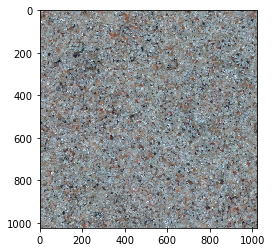

In [4]:
#show augs

how_many = 1
#how_many = batch size

x = train_generator.next()

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    plt.imshow(image.squeeze())   #squeeze for grayscale images
    print('Stats :', x[1][i])
    plt.show()

In [5]:
#model
baseFilter = 32
baseKernel = 5
initializer = tf.keras.initializers.HeNormal()


model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    
    layers.SeparableConv2D(filters = baseFilter, kernel_size=baseKernel, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.SeparableConv2D(baseFilter*2, baseKernel, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*3, baseKernel, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*4, baseKernel, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*5, baseKernel, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*6, baseKernel, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*7, baseKernel, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    
    layers.GlobalMaxPooling2D(),

    layers.Dense(128, activation='relu', kernel_initializer=initializer),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_initializer=initializer),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_initializer=initializer),
    layers.Dropout(0.5),
    layers.Dense(len(columns), activation="linear")
])


model._name = "SandCam_CNN"

model.summary()


Model: "SandCam_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 1024, 1024, 32)    203       
_________________________________________________________________
batch_normalization (BatchNo (None, 1024, 1024, 32)    128       
_________________________________________________________________
activation (Activation)      (None, 1024, 1024, 32)    0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 1024, 1024, 64)    2912      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 1024, 64)    256       
_________________________________________________________________
activation_1 (Activation)    (None, 1024, 1024, 64)    0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 64)      

In [6]:
# define other metrics
metrics = tf.keras.metrics.MeanAbsolutePercentageError(name='mape')

In [7]:
#compile
#by plotting a loss curve, min occurs w/ Adam() at lr = 1e-2. but i am gettign better results by using default lr.

model.compile(loss='mean_squared_error', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics = metrics
             )

In [8]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 40, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience = 5)

In [9]:
#train the model
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 200,
                    workers = 24,
                    callbacks =[early_stop, reduce_lr])



Epoch 1/200
27/27 [==============================] - 47s 2s/step - loss: 17.0636 - mape: 719.1556 - val_loss: 0.9301 - val_mape: 99.2979
Epoch 2/200
27/27 [==============================] - 46s 2s/step - loss: 1.3408 - mape: 150.2379 - val_loss: 0.9075 - val_mape: 97.2717
Epoch 3/200
27/27 [==============================] - 48s 2s/step - loss: 1.0885 - mape: 115.8320 - val_loss: 0.8719 - val_mape: 93.7698
Epoch 4/200
27/27 [==============================] - 47s 2s/step - loss: 1.0517 - mape: 110.7784 - val_loss: 0.8205 - val_mape: 87.9796
Epoch 5/200
27/27 [==============================] - 47s 2s/step - loss: 0.9933 - mape: 107.3140 - val_loss: 0.7552 - val_mape: 79.7344
Epoch 6/200
27/27 [==============================] - 47s 2s/step - loss: 0.9053 - mape: 113.4659 - val_loss: 0.7121 - val_mape: 74.5125
Epoch 7/200
27/27 [==============================] - 46s 2s/step - loss: 0.8841 - mape: 105.2453 - val_loss: 0.6701 - val_mape: 67.8573
Epoch 8/200
27/27 [============================

Epoch 56/200
27/27 [==============================] - 47s 2s/step - loss: 0.4836 - mape: 77.5607 - val_loss: 0.2771 - val_mape: 39.4708
Epoch 57/200
27/27 [==============================] - 48s 2s/step - loss: 0.4492 - mape: 73.8833 - val_loss: 0.2775 - val_mape: 39.2937
Epoch 58/200
27/27 [==============================] - 48s 2s/step - loss: 0.4652 - mape: 75.9034 - val_loss: 0.2782 - val_mape: 39.2791
Epoch 59/200
27/27 [==============================] - ETA: 0s - loss: 0.4824 - mape: 74.9863
Epoch 00059: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
27/27 [==============================] - 49s 2s/step - loss: 0.4824 - mape: 74.9863 - val_loss: 0.2780 - val_mape: 39.2392
Epoch 60/200
27/27 [==============================] - 46s 2s/step - loss: 0.4798 - mape: 76.3244 - val_loss: 0.2781 - val_mape: 39.2023
Epoch 61/200
27/27 [==============================] - 46s 2s/step - loss: 0.5009 - mape: 74.6563 - val_loss: 0.2782 - val_mape: 39.2048
Epoch 62/200
27/27 [===

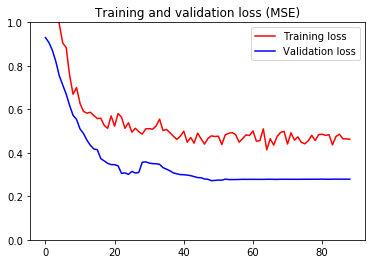

<Figure size 432x288 with 0 Axes>

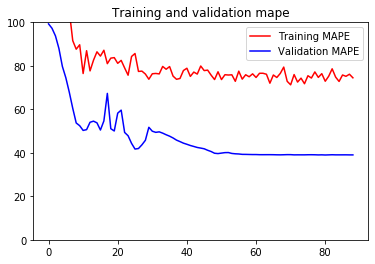

<Figure size 432x288 with 0 Axes>

In [10]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,1)

plt.title('Training and validation loss (MSE)')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mape']
val_mae = history.history['val_mape']

plt.plot(epochs, mae, 'r', label='Training MAPE')
plt.plot(epochs, val_mae, 'b', label='Validation MAPE')
plt.ylim(0,100)

plt.title('Training and validation mape')
plt.legend(loc=0)
plt.figure()
plt.show()


In [11]:
#evaluate full model on test set:
model.evaluate(test_generator)

4/4 [==============================] - 0s 87ms/step - loss: 0.2041 - mape: 45.5484


[0.2041475921869278, 45.54844665527344]

Stats : [0.216 0.264 0.318 0.371 0.444 0.672 0.929 1.073 1.197 1.371 1.579]
Predicted Stats: [[0.17930883 0.18403862 0.24181499 0.23544267 0.31122714 0.44491702
  0.63292694 0.8385403  1.0216401  1.2852196  1.5924463 ]]


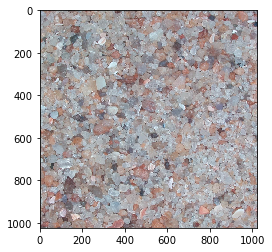

In [12]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [13]:
#save the model
filepath = './models/SNmodel_K5_split'
model.save(filepath)


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./models/SNmodel_K5_split/assets


In [14]:
#reload model, if needed
#model = tf.keras.models.load_model('./models/SNmodel_K5_split')
#model.summary()

In [15]:
#quantize all layers but dense iwth not isinstance

# Helper function  to annotate all non dense layters
def apply_quantization_to_not_dense(layer):
  if not isinstance(layer, (tf.keras.layers.Dense,tf.keras.layers.Dropout)):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense` 
# to the layers of the model.
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function = apply_quantization_to_not_dense,
)


# Now that non- Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()


Model: "SandCam_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer (QuantizeLaye (None, 1024, 1024, 3)     3         
_________________________________________________________________
quant_depthwise_conv2d (Quan (None, 1024, 1024, 3)     80        
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 1024, 1024, 32)    193       
_________________________________________________________________
quant_batch_normalization (Q (None, 1024, 1024, 32)    129       
_________________________________________________________________
quant_activation (QuantizeWr (None, 1024, 1024, 32)    3         
_________________________________________________________________
quant_depthwise_conv2d_1 (Qu (None, 1024, 1024, 32)    805       
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 1024, 1024, 64)    

In [16]:
#delete old model
del model
del annotated_model

Epoch 1/10
27/27 [==============================] - 49s 2s/step - loss: 0.5097 - mape: 67.8496 - val_loss: 0.3271 - val_mape: 45.4836
Epoch 2/10
27/27 [==============================] - 51s 2s/step - loss: 0.5064 - mape: 75.1812 - val_loss: 0.3310 - val_mape: 47.3168
Epoch 3/10
27/27 [==============================] - 52s 2s/step - loss: 0.4991 - mape: 75.8823 - val_loss: 0.3289 - val_mape: 44.3824
Epoch 4/10
27/27 [==============================] - 51s 2s/step - loss: 0.4831 - mape: 77.2808 - val_loss: 0.3353 - val_mape: 43.2116
Epoch 5/10
27/27 [==============================] - 50s 2s/step - loss: 0.5175 - mape: 76.6501 - val_loss: 0.3395 - val_mape: 41.1823
Epoch 6/10
27/27 [==============================] - ETA: 0s - loss: 0.5100 - mape: 76.8744
Epoch 00006: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
27/27 [==============================] - 51s 2s/step - loss: 0.5100 - mape: 76.8744 - val_loss: 0.3390 - val_mape: 43.2489
Epoch 7/10
27/27 [=================

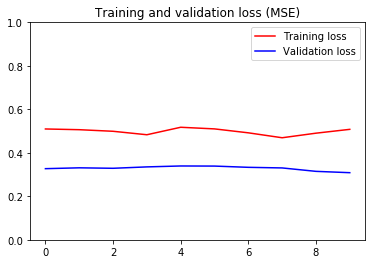

<Figure size 432x288 with 0 Axes>

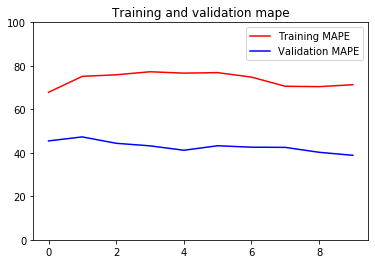

<Figure size 432x288 with 0 Axes>

In [17]:
# `quantize_model` requires a recompile.
quant_aware_model.compile(loss='mean_squared_error', 
              optimizer=tf.keras.optimizers.Adam(lr = 0.0001), 
              metrics = metrics
             )

#retrain with low learning rate:

quant2_history = quant_aware_model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs= 10,
                    workers = 8,
                    callbacks =[early_stop, reduce_lr])

#look at the metrics from training
%matplotlib inline

loss = quant2_history.history['loss']
val_loss = quant2_history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,1)

plt.title('Training and validation loss (MSE)')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = quant2_history.history['mape']
val_mae = quant2_history.history['val_mape']

plt.plot(epochs, mae, 'r', label='Training MAPE')
plt.plot(epochs, val_mae, 'b', label='Validation MAPE')
plt.ylim(0,100)

plt.title('Training and validation mape')
plt.legend(loc=0)
plt.figure()
plt.show()

In [18]:
#evaluate full model on test set:
quant_aware_model.evaluate(test_generator)

4/4 [==============================] - 0s 74ms/step - loss: 0.2205 - mape: 46.8410


[0.22047266364097595, 46.84099197387695]

Stats : [0.14  0.155 0.17  0.182 0.197 0.234 0.285 0.315 0.346 0.389 0.446]
Predicted Stats: [[0.1231982  0.1984343  0.15620077 0.20863745 0.2876771  0.30757582
  0.53377587 0.6877141  0.7585887  1.0385362  1.2370782 ]]


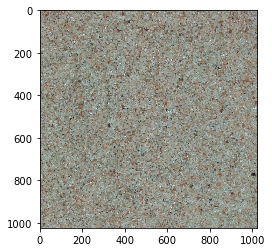

In [19]:
# use the validation generator as a sanity check

x = validation_generator.next()

how_many = 1
#how_many = batch_size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = quant_aware_model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [20]:
#TF lite converter for the QAT model

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model2 = converter.convert()

import pathlib

tflite_models_dir = pathlib.Path("TFL_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"SandCam_QAT_notdense.tflite"
tflite_model_file.write_bytes(quantized_tflite_model2)

!ls -lh {tflite_models_dir}

INFO:tensorflow:Assets written to: /tmp/tmp7cr8_iqj/assets
total 1.6M
-rw-rw-r-- 1 ebgoldstein ebgoldstein 398K Jan 21 13:06 SandCam_QAT_notdense.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 241K Jan 20 15:57 SandCam_QAT.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 635K Jan 20 12:01 SandCam_quant_16.tflite
-rw-rw-r-- 1 ebgoldstein ebgoldstein 342K Jan 20 12:01 SandCam_quant_DR.tflite


In [21]:
#Load QAT model into TFlite intepreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

Stats : [0.194 0.228 0.268 0.309 0.367 0.55  0.774 0.867 0.961 1.085 1.29 ]
Predicted Stats: [[0.13873288 0.17147052 0.21898706 0.27514505 0.31648195 0.4692532
  0.6099943  0.78233886 0.96096396 1.2494755  1.4895871 ]]


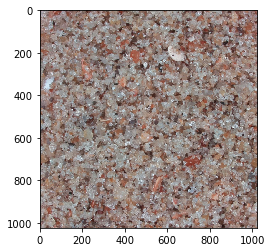

In [27]:
#Sanity check on image 

#SET THE IMAGE
Timage = validation_generator.next()
test_image = np.expand_dims(Timage[0][1],axis=0)

#dynamic range quant
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictionsQAT = interpreter.get_tensor(output_index)

plt.imshow(Timage[0][1])

print('Stats :',Timage[1][1])
print('Predicted Stats:', predictionsQAT)

plt.grid(False)

In [23]:
#evaluate TFLite model on test images (MSE).. loiop through each image, predict with intepreter, sum MSE, get average MSE across all sample

In [24]:
#compile the tflite model for edge tpu via: 
#https://github.com/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb
#https://colab.research.google.com/github/google-coral/tutorials/blob/master/compile_for_edgetpu.ipynb